# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D. 

## PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [1]:
import numpy as np 
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
import scipy
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
K = [[7.070912e+02, 0.000000e+00, 6.018873e+02],
     [0.000000e+00, 7.070912e+02, 1.831104e+02],
     [0.000000e+00, 0.000000e+00, 1.000000e+00]]
baseline = 0.53790448812

In [4]:
def writePointCloud(vertices, colors, filename):
    colors = colors.reshape(-1,3)
    vertices = np.hstack([vertices.reshape(-1,3), colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [5]:
def disparityMap(L, R):
    left_image = cv2.imread(L)
    right_image = cv2.imread(R)
    left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
    right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
        
    stereo = cv2.StereoSGBM_create(minDisparity = 16,
       numDisparities = 128,
       blockSize = 7,
       disp12MaxDiff = 1,
       speckleWindowSize = 100,
       speckleRange = 2,
       uniquenessRatio = 12,
       P1 = 8*3*7*7,
       P2 = 32*3*7*7,
    )
    
    disparity = stereo.compute(left_image, right_image).astype(np.float32) / 16.0
    return disparity

In [6]:
def read_transformations(filename='../data/poses.txt'):
    f = open(filename, 'r')
    lines = f.readlines()
    transformation_list = []
    for i in range(len(lines)):
        transformation_list_temp = lines[i].split()
        temp_rot = [] 
        temp_rot.append( (transformation_list_temp[0:4] ) ) 
        temp_rot.append( (transformation_list_temp[4:8]  ) ) 
        temp_rot.append( (transformation_list_temp[8:12]  ) ) 
        transformation_list.append(np.array(temp_rot,dtype = np.float32))
    return transformation_list

In [7]:
poses = read_transformations()
left_images = '../data/img2'
right_images = '../data/img3'

In [51]:
for image in sorted(os.listdir(left_images)):
    left_image = os.path.join(left_images, image)
    right_image = os.path.join(right_images, image)
    disparity = disparityMap(left_image, right_image)
    img = cv2.imread(left_image)
    
    cx = K[0][2]
    cy = K[1][2]
    f = 7.070912e+02
    Q = np.float32([[1, 0, 0, -cx],
                        [0, 1, 0, -cy], 
                        [0, 0, 0, f], 
                        [0, 0, -1/baseline,  0]])
    
    # 3D points
    points = cv2.reprojectImageTo3D(disparity, Q)
    colors = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    #filtered = disparity > disparity.min()
    #points = points[filtered]
    #colors = colors[filtered]
    
    writePointCloud(points, colors,  os.path.join('../pointclouds', image[: -4] + ".ply"))

In [6]:
finalpcd = o3d.geometry.PointCloud()
cnt = 0
for T, filename in zip(poses,sorted(os.listdir('../pointclouds'))):
    #cnt += 1
    pcd = o3d.io.read_point_cloud(os.path.join('../pointclouds', filename))
    #if cnt < 3:
    #    o3d.visualization.draw_geometries([pcd])
    T = T.reshape(3, 4)
    T = np.vstack((T, [0,0,0,1]))
    pcd = pcd.transform(T)
    finalpcd += pcd
    #print(cnt)

In [7]:
o3d.visualization.draw_geometries([finalpcd])

## PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.

In [9]:
R = np.array([[0.7220079,  0.2779921,  0.6335810],
     [0.2779921,  0.7220079, -0.6335810],
     [-0.6335810,  0.6335810, 0.4440158]])
t = np.array([[1], [1], [0]])
Rt = np.hstack((R,t))
P = K@(Rt)
print(P)

[[ 1.29181075e+02  5.77910125e+02  7.15247021e+02  7.07091200e+02]
 [ 8.05504972e+01  6.26540703e+02 -3.66695639e+02  7.07091200e+02]
 [-6.33581000e-01  6.33581000e-01  4.44015800e-01  0.00000000e+00]]


In [10]:
finalpcd_down = finalpcd.voxel_down_sample(voxel_size = 1)
points = np.array(finalpcd_down.points)
print(points.shape)
ones = np.ones((points.shape[0], 1))
world_points = np.hstack((points, ones))
image_points = P@world_points.T
image_points = image_points.T

(1365, 3)


In [11]:
def getResidual(image_points, world_points, p):
    P = p.reshape((3,4))
    residual = []
    n = image_points.shape[0]
    for i in range(n):
        X = world_points[i]
        x = P@X
        e = (image_points[i] - x)**2
        residual.append(np.sum(e))
    return np.array(residual)

In [8]:
def getJacobian(image_points, world_points, P):
    J = np.zeros((world_points.shape[0], 12))
    for i in range(image_points.shape[0]):
        x1, x2, x3 = image_points[i]
        X1, X2, X3, X4 = world_points[i]

        J[i][0]  = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3  - P[3]*X4)* (-X1)
        J[i][1]  = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3  - P[3]*X4)* (-X2)
        J[i][2]  = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3  - P[3]*X4)* (-X3)
        J[i][3]  = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3  - P[3]*X4)* (-X4)
        J[i][4]  = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3  - P[7]*X4)* (-X1)
        J[i][5]  = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3  - P[7]*X4)* (-X2)
        J[i][6]  = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3  - P[7]*X4)* (-X3)
        J[i][7]  = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3  - P[7]*X4)* (-X4)
        J[i][8]  = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X1)
        J[i][9]  = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X2)
        J[i][10] = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X3)
        J[i][11] = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X4)
        
    return J

In [13]:
def getError(image_points, world_points, p):
    residual = getResidual(image_points, world_points, p)
    return np.sum(residual)

In [14]:
def GaussNewton(image_points, world_points, p):
    num_of_iters = 100
    tol = 1e-3
    initialerror = getError(image_points, world_points, p)
    errors = []
    errors.append(initialerror)
    converged = False

    for i in range(num_of_iters):
        residual = getResidual(image_points, world_points, p)
        J = getJacobian(image_points, world_points, p)
        delta = np.linalg.pinv(J.T @ J)@J.T@residual   
        delta = delta.reshape((12,1))
        p = p - delta
        error = getError(image_points, world_points, p)
        errors.append(error)
        
        if error < tol:
            print("Gauss Newton converged in ", str(i+1), " iterations")
            print("Error: ", error)
            converged = True
            break
    if not converged:
        print("Gauss Newton faied to converge in ", str(num_of_iters), " iterations")
        print("Error: ", error)
    return errors, p

#### Initializing p with random values

In [20]:
p = np.random.rand(12,1)*10
errors, est_p = GaussNewton(image_points, world_points, p)

Gauss Newton converged in  26  iterations
Error:  0.00048372468405103895


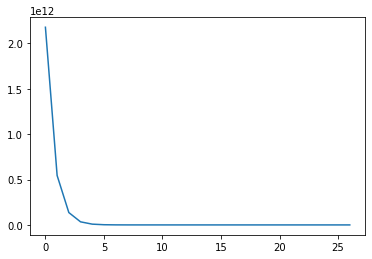

In [21]:
plt.plot(errors)

#### Initializing p with close to initial values

In [22]:
k = 0
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        p[k] = P[i][j] + np.random.rand()
        k += 1
errors, est_p = GaussNewton(image_points, world_points, p)

Gauss Newton converged in  18  iterations
Error:  0.00030531580608638787


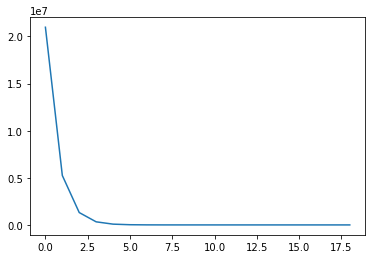

In [23]:
plt.plot(errors)

## PART 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

#### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.